<a href="https://colab.research.google.com/github/tanmaylaud/biospec/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

In [ ]:
features = 32
# define a VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=2053, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=2*features)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=2053)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = F.relu(self.dec2(x))
        return reconstruction, mu, log_var, z

In [ ]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
# import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [ ]:
merged = pd.read_csv('01087_A01_P010739_S00_N01_R1.mzML_merged.csv')
with open('01087_A01_P010739_S00_N01_R1.mzML_spectrum.npz','rb') as f:
    spectrum = np.load(f, allow_pickle=True)
    spectrum = pd.DataFrame.from_dict({item: np.array(spectrum[item]) for item in spectrum.files},orient='index')
spectrum = pd.DataFrame(spectrum[0]['arr_0'], columns=['spectrum','scan_id'])
merged = merged[['scan_id','PrecursorCharge','parent mass','Peptide','Protein']].merge(spectrum,on='scan_id')


print(len(merged.scan_id.unique()))
print(len(merged.PrecursorCharge.unique()))
print(len(merged['parent mass'].unique()))
print(len(merged.Peptide.unique()))
print(len(merged.Protein.unique()))


24567
5
15428
15919
5586


In [ ]:
merged.head()

scan_id  PrecursorCharge  parent mass       Peptide  \
0    9353                3      1078.53  K.FLENEDRR.S   
1   12544                3      1078.54  K.FLENEDRR.S   
2   13941                3      1078.56  K.FLENEDRR.S   
3    9010                3      1078.53  K.FLENEDRR.S   
4   12184                3      1078.53  K.FLENEDRR.S   

                          Protein  \
0  tr|A0A024R6I7|A0A024R6I7_HUMAN   
1  tr|A0A024R6I7|A0A024R6I7_HUMAN   
2  tr|A0A024R6I7|A0A024R6I7_HUMAN   
3  tr|A0A024R6I7|A0A024R6I7_HUMAN   
4  tr|A0A024R6I7|A0A024R6I7_HUMAN   

                                            spectrum  
0    (0, 47)\t0.0042360941879451275\n  (0, 52)\t0...  
1    (0, 34)\t0.002511497586965561\n  (0, 36)\t0....  
2    (0, 51)\t0.0037045099306851625\n  (0, 70)\t0...  
3    (0, 5)\t0.001706607872620225\n  (0, 10)\t0.0...  
4    (0, 79)\t0.006238874047994614\n  (0, 107)\t0...

In [ ]:
# grouped_spectra = {}
peptide1 = {}
charge = {}
mass = {}
spectrum ={}

for d in merged.values:
    if d[3] not in charge:
        peptide1[d[3]] = []
        charge[d[3]] = []
        mass[d[3]] = []
        spectrum[d[3]] = []
        
    peptide1[d[3]].append(d[3])
    charge[d[3]].append(d[1])
    mass[d[3]].append(d[2])
    spectrum[d[3]].append(d[5].toarray())

    
g_s = []
for g in charge:
    g_s.append((g, np.array(peptide1[g]), np.array(charge[g]), np.array(mass[g]), np.concatenate(spectrum[g])))
    
spec = pd.DataFrame(g_s,columns=['peptide','peptide1','charge', 'mass', 'spectrum'])
data = spec[spec.apply(lambda x: len(x['charge'])>1,axis=1)]
allpeptide = data['peptide'].values
allpeptide1 = np.concatenate(data['peptide1'].values)
allcharge = np.expand_dims(np.concatenate(data['charge'].values).astype(np.float32),1)
allmass = np.expand_dims(np.concatenate(data['mass'].values).astype(np.float32),1)
allspectrum = np.concatenate(data['spectrum'].values).astype(np.float32)

# mean_charge = np.mean(allcharge)
# std_charge = np.std(allcharge)
# normalize_charge = (allcharge - mean_charge)/std_charge
normalize_charge = np.log(allcharge)
print(np.max(np.abs(normalize_charge)))
print(normalize_charge.shape)

# mean_mass = np.mean(allmass)
# std_mass = np.std(allmass)
# normalize_mass = (allmass - mean_mass)/std_mass
normalize_mass = np.log(allmass)
print(np.max(np.abs(normalize_mass)))
print(normalize_mass.shape)

# mean_sp = np.mean(allspectrum)
# std_sp = np.std(allspectrum)
# normalize_sp = (allspectrum - mean_sp)/std_sp
normalize_sp = allspectrum
# print(np.max(np.abs(allspectrum)))
print(np.max(np.abs(normalize_sp)))
print(normalize_sp.shape)


normalize_data = np.concatenate([normalize_charge, normalize_mass, normalize_sp],1)
print(normalize_data.shape)

1.7917595
(12698, 1)
8.558061
(12698, 1)
0.97648275
(12698, 2051)
(12698, 2053)


In [ ]:
print(allpeptide1.shape)
print(allpeptide.shape)
print(allspectrum.shape)

(12698,)
(3964,)
(12698, 2051)


In [ ]:
data

peptide  \
0                                           K.FLENEDRR.S   
1                                           K.IREEYPDR.I   
2                                          K.QLLHLAEEK.A   
5                                  R.ALMNLH(N,1.982)NR.C   
10                                L.(C,57.021)IEDGSIHR.I   
...                                                  ...   
15881               -.DYAGVFSDAGLTFTSSSG(Q,0.984)QTAQR.-   
15892  R.SLSEGDIT(C,57.021)SVGFIPVDG(C,57.021)I(C,57....   
15899  R.SLSEGDIT(C,57.021)SVGFIPVD(G,16.002)(C,57.02...   
15909  R.RP(C,57.021)FSALEVDETYVPKEFNA(E,12.093)TFTFH...   
15911                       -.TLNQPDSQLQLTTGNGLFLSEGLK.-   

                                                peptide1  \
0      [K.FLENEDRR.S, K.FLENEDRR.S, K.FLENEDRR.S, K.F...   
1                           [K.IREEYPDR.I, K.IREEYPDR.I]   
2                         [K.QLLHLAEEK.A, K.QLLHLAEEK.A]   
5         [R.ALMNLH(N,1.982)NR.C, R.ALMNLH(N,1.982)NR.C]   
10      [L.(C,57.021)IEDGSIHR.I, L.(C,57.021)IEDGSIHR.I]   
...                                                  ...   
15881  [-.DYAGVFSDAGLTFTSSSG(Q,0.984)QTAQR.-, -.DYAGV...   
15892  [R.SLSEGDIT(C,57.021)SVGFIPVDG(C,57.021)I(C,57...   
15899  [R.SLSEGDIT(C,57.021)SVGFIPVD(G,16.002)(C,57.0...   
15909  [R.RP(C,57.021)FSALEVDETYVPKEFNA(E,12.093)TFTF...   
15911  [-.TLNQPDSQLQLTTGNGLFLSEGLK.-, -.TLNQPDSQLQLTT...   

                                                  charge  \
0      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
1                                                 [3, 3]   
2                                                 [3, 2]   
5                                                 [3, 3]   
10                                                [3, 3]   
...                                                  ...   
15881                                             [2, 2]   
15892                                          [2, 2, 2]   
15899                                             [2, 2]   
15909                                             [3, 3]   
15911                                             [2, 2]   

                                                    mass  \
0      [1078.53, 1078.54, 1078.56, 1078.53, 1078.53, ...   
1                                     [1078.53, 1078.53]   
2                                      [1080.6, 1080.61]   
5                                     [1084.51, 1084.53]   
10                                     [1086.49, 1086.5]   
...                                                  ...   
15881                                 [2495.17, 2495.15]   
15892                        [2511.15, 2511.17, 2511.16]   
15899                                 [2527.15, 2527.17]   
15909                                 [3819.86, 3819.86]   
15911                                 [2574.35, 2574.33]   

                                                spectrum  
0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
5      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
10     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
...                                                  ...  
15881  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
15892  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
15899  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
15909  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
15911  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[3964 rows x 5 columns]

In [ ]:
epochs = 50
batch_size = 256
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# train and validation data

train_data,val_data,test_data = torch.utils.data.random_split(
    normalize_data,[int(normalize_data.__len__()*0.8),int(normalize_data.__len__()*0.1)+1,
                    int(normalize_data.__len__()*0.1)+1])

all_data = normalize_data

In [ ]:
print(np.max(all_data))
print(np.min(all_data))

8.558061
0.0


In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(all_data.shape)

10158
1270
1270
(12698, 2053)


In [ ]:
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)
all_loader = DataLoader(
    all_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def final_loss(reconstruction, data, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param reconstruction: prediction
    :param data: truth
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MAE = torch.mean(torch.abs(reconstruction - data))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     print(MAE, KLD)
    return MAE + KLD

In [ ]:
def embed(model, dataloader):
    model.eval()
    running_loss = 0.0
    z_list = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(all_data)/dataloader.batch_size)):
            data = data.to(device)

            _,_,_,z = model(data)
            z_list.append(z)

    return torch.cat(z_list)

In [ ]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
#         data, _ = data
        data = data.to(device)
#         data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar,_ = model(data)
#         bce_loss = criterion(reconstruction, data)
        loss = final_loss(reconstruction, data, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [ ]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
#             data, _ = data
            data = data.to(device)
#             data = data.view(data.size(0), -1)
            reconstruction, mu, logvar,_ = model(data)
#             bce_loss = criterion(reconstruction, data)
            loss = final_loss(reconstruction, data, mu, logvar)
            running_loss += loss.item()
        
#             # save the last batch input and output of every epoch
#             if i == int(len(val_data)/dataloader.batch_size) - 1:
#                 num_rows = 8
#                 both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
#                                   reconstruction.view(batch_size, 1, 28, 28)[:8]))
#                 save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [ ]:
train_loss = []
val_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    test_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.8f}")
    print(f"Val Loss: {val_epoch_loss:.8f}")
    print(f"Test Loss: {test_epoch_loss:.8f}")

  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Epoch 1 of 50


40it [00:02, 14.75it/s]                        
5it [00:00, 40.48it/s]               
5it [00:00, 36.17it/s]                       
  3%|▎         | 1/39 [00:00<00:05,  6.92it/s]

Train Loss: 0.00440412
Val Loss: 0.00018356
Test Loss: 0.00018480
Epoch 2 of 50


40it [00:03, 13.12it/s]                        
5it [00:00, 42.51it/s]               
5it [00:00, 44.95it/s]               
  5%|▌         | 2/39 [00:00<00:02, 13.45it/s]

Train Loss: 0.00008026
Val Loss: 0.00004204
Test Loss: 0.00004334
Epoch 3 of 50


40it [00:02, 14.14it/s]                        
5it [00:00, 37.31it/s]                       
5it [00:00, 43.47it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.93it/s]

Train Loss: 0.00003526
Val Loss: 0.00003186
Test Loss: 0.00003293
Epoch 4 of 50


40it [00:02, 14.81it/s]                        
5it [00:00, 44.95it/s]               
5it [00:00, 33.62it/s]                       
  5%|▌         | 2/39 [00:00<00:03, 12.21it/s]

Train Loss: 0.00002737
Val Loss: 0.00002679
Test Loss: 0.00002774
Epoch 5 of 50


40it [00:02, 14.56it/s]                        
5it [00:00, 46.79it/s]               
5it [00:00, 42.84it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.48it/s]

Train Loss: 0.00002299
Val Loss: 0.00002365
Test Loss: 0.00002449
Epoch 6 of 50


40it [00:02, 16.49it/s]                        
5it [00:00, 43.76it/s]               
5it [00:00, 45.68it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.11it/s]

Train Loss: 0.00002008
Val Loss: 0.00002137
Test Loss: 0.00002213
Epoch 7 of 50


40it [00:02, 16.52it/s]                        
5it [00:00, 44.60it/s]               
5it [00:00, 44.54it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.16it/s]

Train Loss: 0.00001804
Val Loss: 0.00001985
Test Loss: 0.00002044
Epoch 8 of 50


40it [00:02, 15.83it/s]                        
5it [00:00, 42.69it/s]               
5it [00:00, 43.64it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.06it/s]

Train Loss: 0.00001638
Val Loss: 0.00001833
Test Loss: 0.00001895
Epoch 9 of 50


40it [00:02, 15.24it/s]                        
5it [00:00, 44.00it/s]               
5it [00:00, 44.79it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.65it/s]

Train Loss: 0.00001513
Val Loss: 0.00001738
Test Loss: 0.00001783
Epoch 10 of 50


40it [00:02, 15.79it/s]                        
5it [00:00, 43.15it/s]               
5it [00:00, 43.70it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.53it/s]

Train Loss: 0.00001395
Val Loss: 0.00001617
Test Loss: 0.00001654
Epoch 11 of 50


40it [00:02, 15.36it/s]                        
5it [00:00, 42.54it/s]               
5it [00:00, 39.27it/s]                       
  5%|▌         | 2/39 [00:00<00:02, 13.69it/s]

Train Loss: 0.00001298
Val Loss: 0.00001535
Test Loss: 0.00001564
Epoch 12 of 50


40it [00:02, 16.15it/s]                        
5it [00:00, 45.89it/s]               
5it [00:00, 45.01it/s]               
  5%|▌         | 2/39 [00:00<00:02, 16.20it/s]

Train Loss: 0.00001225
Val Loss: 0.00001432
Test Loss: 0.00001459
Epoch 13 of 50


40it [00:02, 14.85it/s]                        
5it [00:00, 41.55it/s]               
5it [00:00, 20.45it/s]                       
  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.00001128
Val Loss: 0.00001364
Test Loss: 0.00001389
Epoch 14 of 50


40it [00:02, 13.51it/s]                        
5it [00:00, 45.10it/s]               
5it [00:00, 40.68it/s]                       
  5%|▌         | 2/39 [00:00<00:02, 15.33it/s]

Train Loss: 0.00001063
Val Loss: 0.00001286
Test Loss: 0.00001304
Epoch 15 of 50


40it [00:02, 14.34it/s]                        
5it [00:00, 47.54it/s]               
5it [00:00, 45.66it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.97it/s]

Train Loss: 0.00001002
Val Loss: 0.00001235
Test Loss: 0.00001248
Epoch 16 of 50


40it [00:02, 13.87it/s]                        
5it [00:00, 36.75it/s]                       
5it [00:00, 46.86it/s]               
  5%|▌         | 2/39 [00:00<00:02, 13.46it/s]

Train Loss: 0.00000944
Val Loss: 0.00001158
Test Loss: 0.00001171
Epoch 17 of 50


40it [00:02, 14.05it/s]                        
5it [00:00, 46.12it/s]               
5it [00:00, 43.67it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.41it/s]

Train Loss: 0.00000887
Val Loss: 0.00001100
Test Loss: 0.00001112
Epoch 18 of 50


40it [00:02, 15.21it/s]                        
5it [00:00, 46.05it/s]               
5it [00:00, 47.95it/s]               
  5%|▌         | 2/39 [00:00<00:02, 13.36it/s]

Train Loss: 0.00000831
Val Loss: 0.00001040
Test Loss: 0.00001046
Epoch 19 of 50


40it [00:02, 13.42it/s]                        
5it [00:00, 37.79it/s]                       
5it [00:00, 46.37it/s]               
  5%|▌         | 2/39 [00:00<00:02, 12.86it/s]

Train Loss: 0.00000779
Val Loss: 0.00000989
Test Loss: 0.00000990
Epoch 20 of 50


40it [00:02, 14.55it/s]                        
5it [00:00, 44.46it/s]               
5it [00:00, 46.25it/s]               
  5%|▌         | 2/39 [00:00<00:02, 13.57it/s]

Train Loss: 0.00000740
Val Loss: 0.00000938
Test Loss: 0.00000940
Epoch 21 of 50


40it [00:02, 14.27it/s]                        
5it [00:00, 44.00it/s]               
5it [00:00, 43.19it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.66it/s]

Train Loss: 0.00000696
Val Loss: 0.00000894
Test Loss: 0.00000891
Epoch 22 of 50


40it [00:02, 15.37it/s]                        
5it [00:00, 43.65it/s]               
5it [00:00, 41.44it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.21it/s]

Train Loss: 0.00000662
Val Loss: 0.00000849
Test Loss: 0.00000851
Epoch 23 of 50


40it [00:02, 14.99it/s]                        
5it [00:00, 46.65it/s]               
5it [00:00, 42.39it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.30it/s]

Train Loss: 0.00000631
Val Loss: 0.00000813
Test Loss: 0.00000807
Epoch 24 of 50


40it [00:02, 14.95it/s]                        
5it [00:00, 46.71it/s]               
5it [00:00, 44.92it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.03it/s]

Train Loss: 0.00000596
Val Loss: 0.00000783
Test Loss: 0.00000770
Epoch 25 of 50


40it [00:02, 15.75it/s]                        
5it [00:00, 46.50it/s]               
5it [00:00, 45.61it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.85it/s]

Train Loss: 0.00000571
Val Loss: 0.00000751
Test Loss: 0.00000739
Epoch 26 of 50


40it [00:02, 15.25it/s]                        
5it [00:00, 45.05it/s]               
5it [00:00, 45.17it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.85it/s]

Train Loss: 0.00000545
Val Loss: 0.00000720
Test Loss: 0.00000711
Epoch 27 of 50


40it [00:02, 15.11it/s]                        
5it [00:00, 46.47it/s]               
5it [00:00, 47.05it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.66it/s]

Train Loss: 0.00000526
Val Loss: 0.00000693
Test Loss: 0.00000682
Epoch 28 of 50


40it [00:02, 15.26it/s]                        
5it [00:00, 45.95it/s]               
5it [00:00, 45.02it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.73it/s]

Train Loss: 0.00000511
Val Loss: 0.00000674
Test Loss: 0.00000656
Epoch 29 of 50


40it [00:02, 14.79it/s]                        
5it [00:00, 46.44it/s]               
5it [00:00, 53.49it/s]               
  5%|▌         | 2/39 [00:00<00:02, 14.14it/s]

Train Loss: 0.00000496
Val Loss: 0.00000674
Test Loss: 0.00000646
Epoch 30 of 50


40it [00:02, 14.96it/s]                        
5it [00:00, 42.38it/s]               
5it [00:00, 37.13it/s]                       
  3%|▎         | 1/39 [00:00<00:03,  9.56it/s]

Train Loss: 0.00000480
Val Loss: 0.00000637
Test Loss: 0.00000610
Epoch 31 of 50


40it [00:04,  9.71it/s]                        
5it [00:00, 48.21it/s]               
5it [00:00, 48.86it/s]               
  5%|▌         | 2/39 [00:00<00:03, 11.91it/s]

Train Loss: 0.00000464
Val Loss: 0.00000616
Test Loss: 0.00000590
Epoch 32 of 50


40it [00:03, 11.37it/s]                        
5it [00:00, 41.41it/s]               
5it [00:00, 46.61it/s]               
  5%|▌         | 2/39 [00:00<00:03, 10.54it/s]

Train Loss: 0.00000453
Val Loss: 0.00000601
Test Loss: 0.00000581
Epoch 33 of 50


40it [00:02, 13.47it/s]                        
5it [00:00, 31.87it/s]                       
5it [00:00, 21.06it/s]                       
  3%|▎         | 1/39 [00:00<00:04,  7.78it/s]

Train Loss: 0.00000440
Val Loss: 0.00000577
Test Loss: 0.00000554
Epoch 34 of 50


40it [00:03, 10.34it/s]                        
5it [00:00, 20.87it/s]                       
5it [00:00, 26.13it/s]                       
  5%|▌         | 2/39 [00:00<00:03, 10.77it/s]

Train Loss: 0.00000428
Val Loss: 0.00000558
Test Loss: 0.00000534
Epoch 35 of 50


40it [00:08,  4.88it/s]                        
5it [00:00, 16.46it/s]                       
5it [00:00, 25.21it/s]                       
  3%|▎         | 1/39 [00:00<00:04,  7.70it/s]

Train Loss: 0.00000417
Val Loss: 0.00000540
Test Loss: 0.00000523
Epoch 36 of 50


40it [00:05,  7.96it/s]                        
5it [00:00, 16.67it/s]                       
5it [00:00, 37.20it/s]                       
  5%|▌         | 2/39 [00:00<00:03, 11.12it/s]

Train Loss: 0.00000404
Val Loss: 0.00000532
Test Loss: 0.00000508
Epoch 37 of 50


40it [00:02, 14.28it/s]                        
5it [00:00, 47.92it/s]               
5it [00:00, 46.14it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.17it/s]

Train Loss: 0.00000397
Val Loss: 0.00000512
Test Loss: 0.00000490
Epoch 38 of 50


40it [00:02, 15.22it/s]                        
5it [00:00, 46.13it/s]               
5it [00:00, 49.95it/s]               
  5%|▌         | 2/39 [00:00<00:02, 16.34it/s]

Train Loss: 0.00000390
Val Loss: 0.00000505
Test Loss: 0.00000478
Epoch 39 of 50


40it [00:02, 14.62it/s]                        
5it [00:00, 46.23it/s]               
5it [00:00, 48.01it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.54it/s]

Train Loss: 0.00000386
Val Loss: 0.00000494
Test Loss: 0.00000466
Epoch 40 of 50


40it [00:02, 15.94it/s]                        
5it [00:00, 51.28it/s]               
5it [00:00, 53.06it/s]               
  5%|▌         | 2/39 [00:00<00:02, 16.14it/s]

Train Loss: 0.00000384
Val Loss: 0.00000481
Test Loss: 0.00000462
Epoch 41 of 50


40it [00:02, 14.11it/s]                        
5it [00:00, 41.25it/s]               
5it [00:00, 43.71it/s]               
  5%|▌         | 2/39 [00:00<00:02, 13.35it/s]

Train Loss: 0.00000375
Val Loss: 0.00000481
Test Loss: 0.00000451
Epoch 42 of 50


40it [00:02, 15.28it/s]                        
5it [00:00, 53.69it/s]               
5it [00:00, 40.06it/s]                       
  5%|▌         | 2/39 [00:00<00:02, 15.42it/s]

Train Loss: 0.00000369
Val Loss: 0.00000468
Test Loss: 0.00000442
Epoch 43 of 50


40it [00:02, 14.05it/s]                        
5it [00:00, 47.50it/s]               
5it [00:00, 47.42it/s]               
  5%|▌         | 2/39 [00:00<00:02, 12.59it/s]

Train Loss: 0.00000363
Val Loss: 0.00000463
Test Loss: 0.00000435
Epoch 44 of 50


40it [00:02, 13.58it/s]                        
5it [00:00, 44.86it/s]               
5it [00:00, 46.60it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.34it/s]

Train Loss: 0.00000365
Val Loss: 0.00000454
Test Loss: 0.00000430
Epoch 45 of 50


40it [00:02, 13.56it/s]                        
5it [00:00, 52.93it/s]               
5it [00:00, 57.57it/s]               
  5%|▌         | 2/39 [00:00<00:02, 18.04it/s]

Train Loss: 0.00000371
Val Loss: 0.00000445
Test Loss: 0.00000428
Epoch 46 of 50


40it [00:02, 15.75it/s]                        
5it [00:00, 52.02it/s]               
5it [00:00, 51.04it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.17it/s]

Train Loss: 0.00000368
Val Loss: 0.00000446
Test Loss: 0.00000413
Epoch 47 of 50


40it [00:02, 16.33it/s]                        
5it [00:00, 50.84it/s]               
5it [00:00, 52.07it/s]               
  5%|▌         | 2/39 [00:00<00:02, 15.14it/s]

Train Loss: 0.00000373
Val Loss: 0.00000448
Test Loss: 0.00000418
Epoch 48 of 50


40it [00:02, 16.73it/s]                        
5it [00:00, 56.21it/s]               
5it [00:00, 57.89it/s]               
  5%|▌         | 2/39 [00:00<00:02, 18.16it/s]

Train Loss: 0.00000371
Val Loss: 0.00000453
Test Loss: 0.00000424
Epoch 49 of 50


40it [00:02, 16.18it/s]                        
5it [00:00, 51.41it/s]               
5it [00:00, 54.61it/s]               
  5%|▌         | 2/39 [00:00<00:02, 16.48it/s]

Train Loss: 0.00000431
Val Loss: 0.00000431
Test Loss: 0.00000411
Epoch 50 of 50


40it [00:02, 16.38it/s]                        
5it [00:00, 51.21it/s]               
5it [00:00, 50.73it/s]               

Train Loss: 0.00000373
Val Loss: 0.00000436
Test Loss: 0.00000411


In [ ]:
z_all_samples = embed(model, all_loader)

50it [00:01, 40.46it/s]                        


In [ ]:
z_all_samples_plot = z_all_samples[:30]
print(z_all_samples_plot.shape)

torch.Size([30, 32])


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = z_all_samples_plot.numpy()
tsne = TSNE(n_components=2, n_jobs=-1,init='pca')
X_embedded = tsne.fit_transform(X)
X_embedded.shape

(30, 2)

In [ ]:
np.save('X_embedded.npy',X_embedded)

In [ ]:
allpeptide1_plot = allpeptide1[:30]

allpeptide1_plot1 = np.array(allpeptide1_plot)
print(len(np.unique(allpeptide1_plot1)))

5


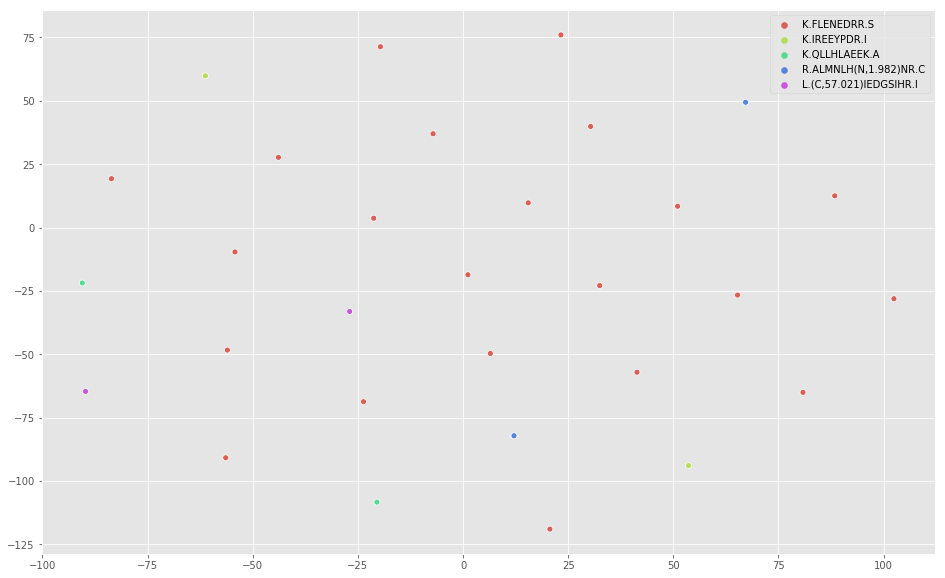

In [ ]:
df_subset = {}
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
df_subset['y'] = allpeptide1_plot
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(allpeptide1_plot1))),
    data=df_subset,
    legend="full"
#     alpha=0.3
)

l2 norm, similarity, 

In [ ]:
import pickle
with open('processed_sia.pickle','rb') as f:
    processed = pickle.load(f)

class SpectrumDataset(Dataset):
    def __init__(self, processed):
        self.data = processed
        self.data_len = len(processed)
  
    def __len__(self):
        return self.data_len

    def __getitem__(self,idx):
        row = self.data[idx]
        return row

dataset = SpectrumDataset(processed)
train_data,valid_data,test_data = torch.utils.data.random_split(dataset,[int(dataset.__len__()*0.8),int(dataset.__len__()*0.1),int(dataset.__len__()*0.1)+1])
print(len(train_data))
print(len(valid_data))
print(len(test_data))
BATCH_SIZE = 256
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

# train_data[0]['x'][0]['spectrum'].shape

len(dataset) #145244

116195
14524
14525


145244

In [ ]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork,self).__init__()
# #         self.encoder = encoder

#     def forward(self,x):
#         x1, x2 = x
#         print('X1',x1['charge'].shape)
#         print('X2',x2['spectrum'].shape)
# #         x1 = self.encoder(x1['spectrum'],x1['mass'],x1['charge'])
# #         x2 = self.encoder(x2['spectrum'],x2['mass'],x2['charge'])
#         #print(x1.shape)

#         return x1, x2
    
def preprocessing(x):
    x1, x2 = x
    
    x1['charge'] = np.log(np.expand_dims(x1['charge'],1))
    x2['charge'] = np.log(np.expand_dims(x2['charge'],1))

    x1['mass'] = np.log(np.expand_dims(x1['mass'],1))
    x2['mass'] = np.log(np.expand_dims(x2['mass'],1))

    x1['spectrum'] = np.squeeze(x1['spectrum'])
    x2['spectrum'] = np.squeeze(x2['spectrum'])
    
    x1 = np.concatenate([x1['charge'], x1['mass'], x1['spectrum']],1)
    x2 = np.concatenate([x2['charge'], x2['mass'], x2['spectrum']],1)
    
#     print('X1',x1['charge'].shape)
#     print('X2',x2['spectrum'].shape)
    return x1, x2

In [ ]:
train = next(iter(train_dataloader))
val = next(iter(valid_dataloader))
test = next(iter(test_dataloader))

In [ ]:
train_data = np.concatenate(preprocessing(train['x'])).astype(float)
val_data = np.concatenate(preprocessing(val['x'])).astype(float)
test_data = np.concatenate(preprocessing(test['x'])).astype(float)
print(train_data.shape, val_data.shape, test_data.shape)

(232390, 2053) (29048, 2053) (29050, 2053)


In [ ]:
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [ ]:
print(batch_size)
print(len(train))

256
4


In [ ]:
# train and validation data

# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
z_train_samples = embed(model, train_loader)
z_val_samples = embed(model, val_loader)
z_test_samples = embed(model, test_loader)

908it [00:19, 47.76it/s]                       
114it [00:02, 50.04it/s]                       
114it [00:02, 51.56it/s]                       


In [ ]:
z_train_samples = z_train_samples.reshape(2,-1,32)
z_val_samples = z_val_samples.reshape(2,-1,32)
z_test_samples = z_test_samples.reshape(2,-1,32)

In [ ]:
print(z_train_samples.shape,z_val_samples.shape,z_test_samples.shape)

torch.Size([2, 116195, 32]) torch.Size([2, 14524, 32]) torch.Size([2, 14525, 32])


In [ ]:
cos = torch.nn.CosineSimilarity(dim=-1)

train_pred = cos(z_train_samples[0],z_train_samples[1]).numpy()
train_truth = train['y'].numpy()

test_pred = cos(z_test_samples[0],z_test_samples[1]).numpy()
test_truth = test['y'].numpy()

df = pd.DataFrame([test_pred,test_truth]).T
df.columns =['y_pred','y_true']

In [ ]:
df

y_pred  y_true
0      0.277488     1.0
1      0.096459     1.0
2     -0.246338     0.0
3     -0.083629     0.0
4      0.172738     0.0
...         ...     ...
14520  0.045000     0.0
14521  0.005126     0.0
14522 -0.048510     0.0
14523  0.130811     0.0
14524  0.059895     0.0

[14525 rows x 2 columns]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
import plotly.express as px
def get_plots(df):
    fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df['y_pred'])
    plt.figure()
    plt.plot(fpr,tpr)
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df['y_pred'])
    plt.figure()
    plt.plot(recall,precision)
    plt.grid(True)
    plt.ylabel('Precision')
    plt.xlabel('Recall')


def get_plotly_plots(df):
    fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df['y_pred'])

    plot_data = pd.DataFrame([fpr,tpr,thresholds]).T
    plot_data.columns = ["fpr","tpr","thresholds"]
    fig = px.line(plot_data,x="fpr",y="tpr",hover_name="thresholds")
    fig.show()

    precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df['y_pred'])
    plot_data = pd.DataFrame([precision,recall,thresholds]).T
    plot_data.columns = ["Precision","Recall","Thresholds"]
    fig = px.line(plot_data,y="Precision",x="Recall",hover_name="Thresholds")
    fig.show()

def get_confusion_matrix(df, threshold=0.0):
    def thres(y):
        if y <= threshold:
            return 0
        return 1  
    df['y_pred_thres'] = df['y_pred'].apply(thres)
    print(classification_report(y_true=df['y_true'],y_pred=df['y_pred_thres']))
    print(confusion_matrix(y_true=df['y_true'],y_pred=df['y_pred_thres']))

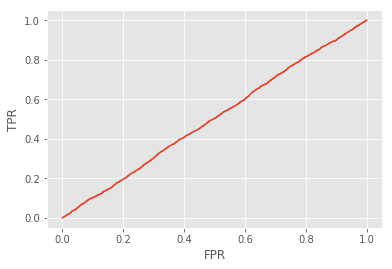

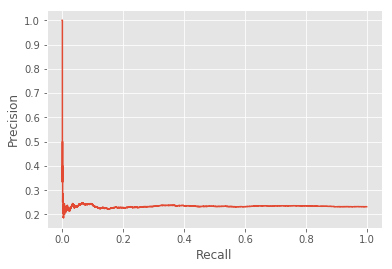

In [ ]:
get_plots(df)

In [ ]:
get_plotly_plots(df)

In [ ]:
# L1 distance 

test_pred = np.sum(torch.abs(z_test_samples[0]-z_test_samples[1]).numpy(),1)
print(test_pred.shape)
test_pred = (test_pred - np.min(test_pred))/(np.max(test_pred) - np.min(test_pred))
test_truth = test['y'].numpy()
print(np.max(test_pred))
print(np.min(test_pred))


(14525,)
1.0
0.0


In [ ]:
df = pd.DataFrame([test_pred,test_truth]).T
df.columns =['y_pred','y_true']
df

y_pred  y_true
0      0.058084     1.0
1      0.287076     1.0
2      0.675189     0.0
3      0.438054     0.0
4      0.293388     0.0
...         ...     ...
14520  0.230569     0.0
14521  0.464819     0.0
14522  0.417339     0.0
14523  0.475939     0.0
14524  0.359747     0.0

[14525 rows x 2 columns]

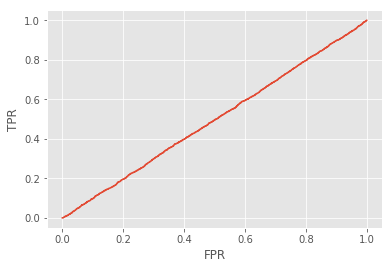

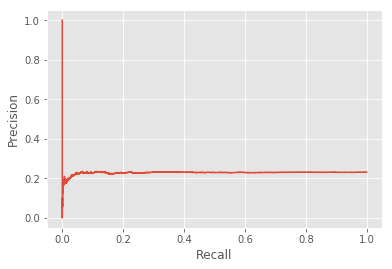

In [ ]:

get_plots(df)


In [ ]:
get_plotly_plots(df)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [ ]:
model.apply(init_weights)

LinearVAE(
  (enc1): Linear(in_features=2053, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=64, bias=True)
  (dec1): Linear(in_features=32, out_features=512, bias=True)
  (dec2): Linear(in_features=512, out_features=2053, bias=True)
)